## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, AveragePooling2D, MaxPool2D, SeparableConv2D, BatchNormalization
from keras.optimizers import Adam, Adagrad, Adadelta
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import  roc_curve, auc, precision_recall_curve, fbeta_score
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
33933,00008888_017.png,No Finding,17,8888,54,F,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00008888_017.png
98974,00026176_001.png,No Finding,1,26176,58,M,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00026176_001.png
14443,00003749_002.png,No Finding,2,3749,48,M,PA,2500,2048,0.168,0.168,NaN,/data/images_002/images/00003749_002.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print(f'We have {len(all_labels)} unique labels and they are: {all_labels}')
i = 2
for label in all_labels:
    # lets create a column based on each disease and set to 1 if the patient has it.
    all_xray_df.insert(i, label, all_xray_df['Finding Labels'].map(lambda str_label: 1.0 if label in str_label else 0))
    i=i+1
pd.set_option('display.max_columns', None) #if set to None the dataframe displays all columns.
all_xray_df.sample(3)

We have 15 unique labels and they are: ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
99389,00026290_001.png,Fibrosis|Pleural_Thickening,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,26290,48,M,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00026290_001.png
62315,00015414_017.png,Infiltration,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,17,15414,40,M,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00015414_017.png
110882,00030235_000.png,Consolidation|Hernia,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,30235,67,M,PA,2544,3056,0.139,0.139,NaN,/data/images_012/images/00030235_000.png


In [4]:
# Get rid of data that is not related to Pneumonia (other diseases)
indexes = (all_xray_df['Pneumonia']==1) | (all_xray_df['No Finding']==1)
all_xray_df.drop(all_xray_df[~indexes].index, inplace=True)

In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].map(lambda x: '1' if x==1.0 else '0')
all_xray_df[['Pneumonia', 'No Finding','pneumonia_class']]

,Pneumonia,No Finding,pneumonia_class
3,0.0,1.0,0
13,0.0,1.0,0
14,0.0,1.0,0
15,0.0,1.0,0
16,0.0,1.0,0
...,...,...,...
112115,1.0,0.0,1
112116,0.0,1.0,0
112117,0.0,1.0,0
112118,0.0,1.0,0


## Create your training and testing data:

In [6]:
def create_splits(df, stratify):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data = train_test_split(df, test_size=0.2, stratify=stratify)
    
    return train_data, val_data

In [7]:
train_data, validation_data = create_splits(all_xray_df, stratify=all_xray_df['pneumonia_class'])

In [8]:
print(f'Total data size: {len(all_xray_df)}')
print(f'Pneumonia training data size: {len(train_data)}')
print(f'Pneumonia validation data size: {len(validation_data)}')

Total data size: 61792
Pneumonia training data size: 49433
Pneumonia validation data size: 12359


In [9]:
train_ratio = train_data['Pneumonia'].sum()/len(train_data)
validation_ratio = validation_data['Pneumonia'].sum()/len(validation_data)
print(f'Ratio Pneumonia_cases/total_cases -- Training: {train_ratio}, Validation: {validation_ratio}')

Ratio Pneumonia_cases/total_cases -- Training: 0.02316266461675399, Validation: 0.023141030827736872


In [10]:
print(f'Data - training percentage: {len(train_data)/len(all_xray_df)*100}%,\
 Validation percentage: {len(validation_data)/len(all_xray_df)*100}%')

Data - training percentage: 79.99902900051787%, Validation percentage: 20.000970999482135%


**Comment:** From the above results, we can affirm that data was split correctly

#### Data distribution

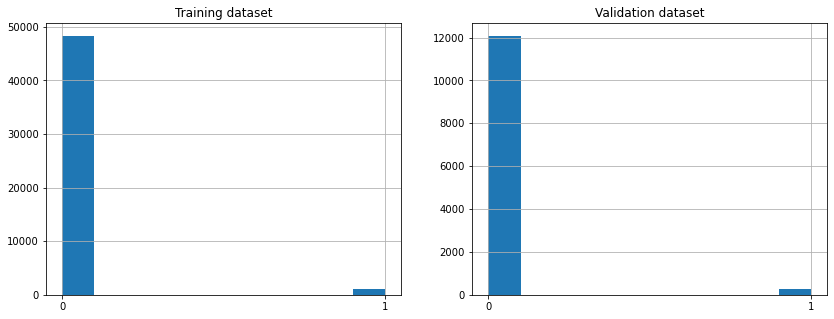

In [11]:
fig = plt.figure(figsize=(14,5))
fig.add_subplot(1,2,1)
train_data['pneumonia_class'].hist();
plt.title('Training dataset')
fig.add_subplot(1,2,2)
validation_data['pneumonia_class'].hist();
plt.title('Validation dataset')
plt.show()

We can see above that data is distributed very unevenly. We need our training data to be equally balanced, in other words, a `positive/negative` ratio of `0.5` since the training process should not be skewed towards any of the classes. Whereas, our validation dataset should have a `positive/negative` proportion of around `0.25` since this resembles a ratio of a real-life scenario. 

To achieve this we will proceed to delete some data.

In [12]:
def Modify_BinaryClass_ratio(dataframe:pd.DataFrame, class_column:str, des_Ratio:float):
    """
        Desired ratio = class_1/(class_1+class_0)
    """
    assert(des_Ratio>=0) & (des_Ratio<=1), "Invalid input ratio, shuld be between 0 and 1"
    class_0_label = dataframe[class_column].unique()[0]
    class_1_label = dataframe[class_column].unique()[1]
    class_0 = dataframe[dataframe[class_column]==class_0_label]
    class_1 = dataframe[dataframe[class_column]==class_1_label]
    if len(class_1)<=len(class_0):
        # this means that we need to remove random samples from class 0
        no_samples = int(len(class_1)*(1-des_Ratio)/des_Ratio) # Number of samples we need 
        result_df = pd.concat([class_0.sample(no_samples), class_1])
    else:
        # this means that we need to remove random samples from class 1
        no_samples = int(len(class_0)*des_Ratio/(1-des_Ratio)) # Number of samples we need 
        result_df = pd.concat([class_0, class_1.sample(no_samples)])
    return result_df

In [13]:
new_train = Modify_BinaryClass_ratio(train_data, 'pneumonia_class', des_Ratio=0.5)
new_valid = Modify_BinaryClass_ratio(validation_data, 'pneumonia_class', des_Ratio=0.25)

In [14]:
train_ratio = new_train['Pneumonia'].sum()/len(new_train)
validation_ratio = new_valid['Pneumonia'].sum()/len(new_valid)
print(f'Ratio Pneumonia_cases/total_cases -- Training: {train_ratio}, Validation: {validation_ratio}')

Ratio Pneumonia_cases/total_cases -- Training: 0.5, Validation: 0.25


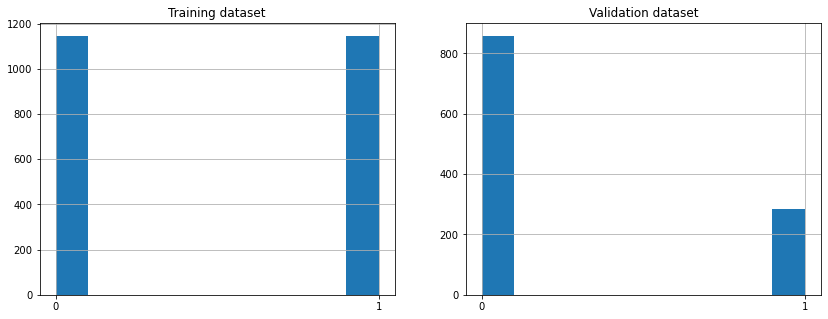

In [15]:
fig = plt.figure(figsize=(14,5))
fig.add_subplot(1,2,1)
new_train['pneumonia_class'].hist();
plt.title('Training dataset')
fig.add_subplot(1,2,2)
new_valid['pneumonia_class'].hist();
plt.title('Validation dataset')
plt.show()

# Now we can begin our model-building & training

#### Image augmentation on your data

To perform image augmentation we shall have in mind that not all augmentation techniques are adequate for images in the healthcare field.
<img src='https://github.com/CheloGE/ML-AI_for_Healthcare-Pneumonia_detection_Chest_X_rays/blob/master/Figures/figure1.jpg?raw=1' width=600px>

From the above images, we can say that:
* Vertical flip is not suitable at all since we will never get up side down images
* Horizontal flip is feasible since the image could be taken in a different perspective AP vs PA
* Shift can be presented but in low percentage
* Rotation only make sense upto 20 degrees
* Shear and zoom can also be presented in a low percentage

Therefore, considering this factors we will create an image augmentation below

In [16]:
def dataframe_preprocess_gen(dataframe, batch_size, augmentation=False, img_size= (224,224), shuffle=False):
    if augmentation:
        ## Normalize and Augment data
        data_gen = ImageDataGenerator(rescale=1.0/255.0, 
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  height_shift_range=0.1,
                                  width_shift_range=0.1,
                                  rotation_range=15,
                                  shear_range=0.1,
                                  zoom_range=0.05)


        
    else:
        ## Only normalize data                                                
        data_gen = ImageDataGenerator(rescale=1./255.0)
    # Apply image generator to dataframe
    new_data = data_gen.flow_from_dataframe(dataframe=dataframe, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = img_size, 
                                          batch_size = batch_size,
                                          shuffle = shuffle, )     

    return new_data

In [17]:
train_gen = dataframe_preprocess_gen(dataframe=Modify_BinaryClass_ratio(train_data, 'pneumonia_class', des_Ratio=0.5), 
                                     batch_size=16, 
                                     augmentation=True, 
                                     img_size=(224,224), 
                                     shuffle=True)

Found 2290 validated image filenames belonging to 2 classes.


In [18]:
val_gen = dataframe_preprocess_gen(dataframe=Modify_BinaryClass_ratio(validation_data, 'pneumonia_class', des_Ratio=0.25), 
                                   batch_size=32, 
                                   augmentation=False, 
                                   img_size=(224,224))

Found 1144 validated image filenames belonging to 2 classes.


In [19]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

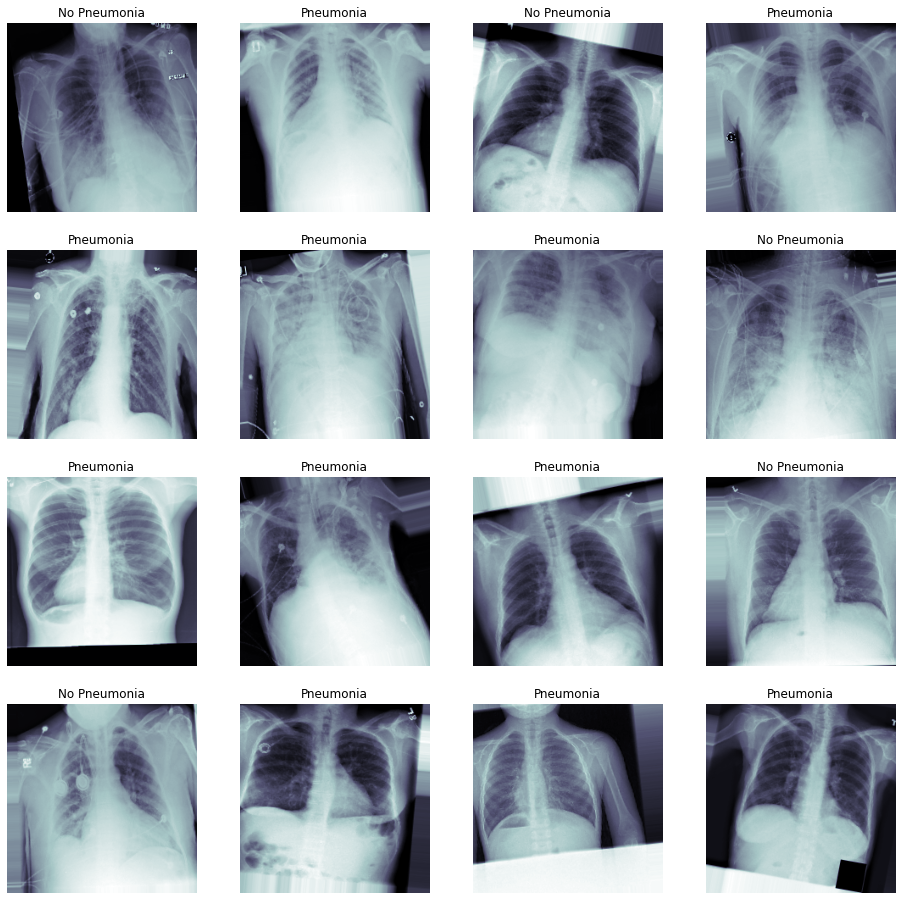

In [20]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

We will use a keras VGG16 model for transfer learning. To understand the model we share an illustration of the model below:
<img src='https://github.com/CheloGE/ML-AI_for_Healthcare-Pneumonia_detection_Chest_X_rays/blob/master/Figures/figure2.jpg?raw=1' width=800px>


In [21]:
def custom_VGG16(learn_from_noLayer:int, init_with_imageNet=False):
    """
        This function loads a VGG model with imagenet weights until learn_from_noLayer layer.
        After that layer, VGG model is initialized by random weights and weights are trainable 
    """
    vgg_imagenet = VGG16(include_top=True, weights='imagenet')
    vgg_normal_weights = VGG16(include_top=True, weights=None)
    layers_imagenet = [l for l in vgg_imagenet.layers]
    layers_normal_weights = [l for l in vgg_normal_weights.layers]
    
    x = layers_imagenet[0].output
    for i in range(1, len(layers_imagenet)):
        if i >= learn_from_noLayer:
            layers_normal_weights[i].trainable = True
            if init_with_imageNet:
                x = layers_imagenet[i](x)
            else:
                x = layers_normal_weights[i](x)
        else:
            layers_imagenet[i].trainable = False
            x = layers_imagenet[i](x)

    new_model = Model(inputs=layers_imagenet[0].input, outputs=x, name='custom_VGG16')
    return new_model

In [22]:
Custom_Vgg_model = custom_VGG16(learn_from_noLayer=17, init_with_imageNet=True)

553467904/553467096 [==============================] - 8s 0us/step


In [23]:
for layer in Custom_Vgg_model.layers:
    print(f'Layer Name: {layer.name}, Trainable? {layer.trainable}')

Layer Name: input_1, Trainable? False
Layer Name: block1_conv1, Trainable? False
Layer Name: block1_conv2, Trainable? False
Layer Name: block1_pool, Trainable? False
Layer Name: block2_conv1, Trainable? False
Layer Name: block2_conv2, Trainable? False
Layer Name: block2_pool, Trainable? False
Layer Name: block3_conv1, Trainable? False
Layer Name: block3_conv2, Trainable? False
Layer Name: block3_conv3, Trainable? False
Layer Name: block3_pool, Trainable? False
Layer Name: block4_conv1, Trainable? False
Layer Name: block4_conv2, Trainable? False
Layer Name: block4_conv3, Trainable? False
Layer Name: block4_pool, Trainable? False
Layer Name: block5_conv1, Trainable? False
Layer Name: block5_conv2, Trainable? False
Layer Name: block5_conv3, Trainable? True
Layer Name: block5_pool, Trainable? True
Layer Name: flatten, Trainable? True
Layer Name: fc1, Trainable? True
Layer Name: fc2, Trainable? True
Layer Name: predictions, Trainable? True


In [24]:
def build_my_model_on_VGG16(pretrained_model, replaceAfterLayer,dropout_prob=0.2):
    
    transfer_layer = pretrained_model.get_layer(replaceAfterLayer)
    vgg_model = Model(inputs = pretrained_model.input, outputs = transfer_layer.get_output_at(1), 
                      name='cutted_custom_VGG16')
    my_model = Sequential(name='myModel')
    my_model.add(vgg_model)
    # Modify the FC classifier
    #my_model.add(MaxPooling2D(pool_size=(2,2)))
    my_model.add(Flatten())
    my_model.add(Dropout(dropout_prob))
    my_model.add(Activation("relu"))
    my_model.add(Dense(1000))
    my_model.add(Activation("relu"))
    my_model.add(Dropout(dropout_prob))
    my_model.add(Dense(1))
    my_model.add(Activation("sigmoid"))
    return my_model

**Comment:** Since in medical field we want to get other features from the X-ray images we will retrain the VGG's model last block while frezing the block before that one. We will also propose a new fully connected classifier block and train it from scratch. That means that the VGG model architecture will remain upto layer `block5_pool` but frozen only upto layer `block4_pool`

In [25]:
# Custom VGG model
myModel = build_my_model_on_VGG16(Custom_Vgg_model, replaceAfterLayer='block5_pool', dropout_prob=0.35)
myModel.summary()

Model: "myModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cutted_custom_VGG16 (Model)  (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
activation_1 (Activation)    (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              25089000  
_________________________________________________________________
activation_2 (Activation)    (None, 1000)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0   

In [26]:
# set optimizer
def setAdam(model, lr):
    loss = 'binary_crossentropy'
    metrics = [tf.keras.metrics.Precision(name='precision'), 'accuracy']#, 
               #tf.keras.metrics.TruePositives(), 
               #tf.keras.metrics.FalsePositives(),
               #tf.keras.metrics.FalseNegatives()]
    model.compile(optimizer=Adam(lr), loss=loss, metrics=metrics)


In [27]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_accuracy', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'max', 
                              save_weights_only = True,
                              period=7)

early = EarlyStopping(monitor='val_loss', 
                       mode= 'min', 
                       patience=10)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=0, verbose=2, mode='min')
hist = CSVLogger('history.csv')

callbacks_list = [checkpoint, early, lr_reduce, hist]

### Start training! 

In [68]:
import random
## train your model
## Parameters
lr = 5e-6
EPOCHS = 25
refreshData = 25 # refresh training data every `refreshData` epochs
setAdam(myModel,lr)

ratio = 0.5
histList = []
for i in range(int(EPOCHS//refreshData)):
    print(f'**************************************** Epoch: {refreshData*i+1} ****************************************')
    print("---------New samples from training data are taken---------")
    #ratio = ratio + 0.01
    print(f"The ratio is: {ratio}")
    train_gen = dataframe_preprocess_gen(dataframe=Modify_BinaryClass_ratio(train_data, 'pneumonia_class', des_Ratio=ratio), 
                                     batch_size=30, 
                                     augmentation=True, 
                                     img_size=(224,224), 
                                     shuffle=True)
    history = myModel.fit_generator(train_gen, 
                                       validation_data = val_gen, 
                                       epochs = refreshData, 
                                       callbacks = callbacks_list)
    #histList.append(history)

**************************************** Epoch: 1 ****************************************
---------New samples from training data are taken---------
The ratio is: 0.5
Found 2290 validated image filenames belonging to 2 classes.
Epoch 1/25
77/77 [==============================] - 78s 1s/step - loss: 0.7604 - precision: 0.5089 - accuracy: 0.5367 - val_loss: 0.7231 - val_precision: 0.4924 - val_accuracy: 0.5656
Epoch 2/25
77/77 [==============================] - 66s 858ms/step - loss: 0.7201 - precision: 0.4849 - accuracy: 0.5646 - val_loss: 0.7900 - val_precision: 0.4832 - val_accuracy: 0.5315

Epoch 00002: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
Epoch 3/25
77/77 [==============================] - 66s 853ms/step - loss: 0.6999 - precision: 0.4862 - accuracy: 0.6087 - val_loss: 0.5869 - val_precision: 0.4967 - val_accuracy: 0.6600
Epoch 4/25
77/77 [==============================] - 66s 853ms/step - loss: 0.6788 - precision: 0.5033 - accuracy: 0.6131 - val_loss:

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

<img src='https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg' width=800px>

**For our project, we will assess specifically `Sensitivity` and `Precision`**


In [28]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
myModel.load_weights(weight_path)
# set validation gen to assess performance
val_gen = dataframe_preprocess_gen(dataframe=Modify_BinaryClass_ratio(validation_data, 'pneumonia_class', des_Ratio=0.25), 
                                   batch_size=100, 
                                   augmentation=False, 
                                   img_size=(224,224),
                                   shuffle = True)


Found 1144 validated image filenames belonging to 2 classes.


In [48]:
valX, val_Y = val_gen.next()
pred_Y = myModel.predict(valX, batch_size = 100, verbose = True)
prediction = pred_Y.reshape(-1)
correct_label = val_Y.reshape(-1)

100/100 [==============================] - 58s 575ms/step


In [94]:
pd.DataFrame({'prediction':prediction, 'label':correct_label}).tail(10)

,prediction,label
90,0.570607,0.0
91,0.523436,0.0
92,0.310397,0.0
93,0.482694,1.0
94,0.378399,0.0
95,0.748418,1.0
96,0.402444,0.0
97,0.758842,1.0
98,0.799252,0.0
99,0.375953,0.0


In [44]:
def plot_auc(label, prediction):
    
    ## roc curve based on https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
    plt.figure(figsize=(15,8))
    fpr, tpr, thresholds = roc_curve(label, prediction)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc}')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.xlabel('False Positive Rate (1-specificity)')
    plt.show()
    return fpr, tpr, thresholds

def plot_prec_recall_curve(label, prediction):
    
    ## roc curve based on https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
    plt.figure(figsize=(15,8))
    precision, recall, thresholds = precision_recall_curve(label, prediction)
    prc_auc = auc(recall, precision)
    plt.title('Precision-Recall Curve (PRC)')
    plt.plot(recall, precision, 'b', label = f'AUCpr = {prc_auc}')
    plt.legend(loc = 'lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Sensitivity')
    plt.show()
    return precision, recall, thresholds
def plot_f_score_thresh(thresholds, fscores):
    # Plot F score vs Thresholds
    plt.figure(figsize=(15,7))
    plt.plot(thresholds, fscores)
    plt.xlabel('Thresholds')
    plt.ylabel('F2-score')
    plt.title('F2 score vs Thresholds')

def plot_history(history):
    plt.figure(figsize=(12, 10))
    legends = ['Training', 'Validation']
    
    plt.subplot(2,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(legends, loc='upper right')
    
    plt.subplot(2,2,2)
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('model precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(legends, loc='lower right')
    
    plt.subplot(2,2,3)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(legends, loc='lower right')
    
    plt.subplot(2,2,4)
    plt.plot(history.history['lr'])
    plt.title('model accuracy')
    plt.ylabel('lr')
    plt.xlabel('epoch')
    plt.legend(['lr'], loc='upper right')
    
    plt.tight_layout()

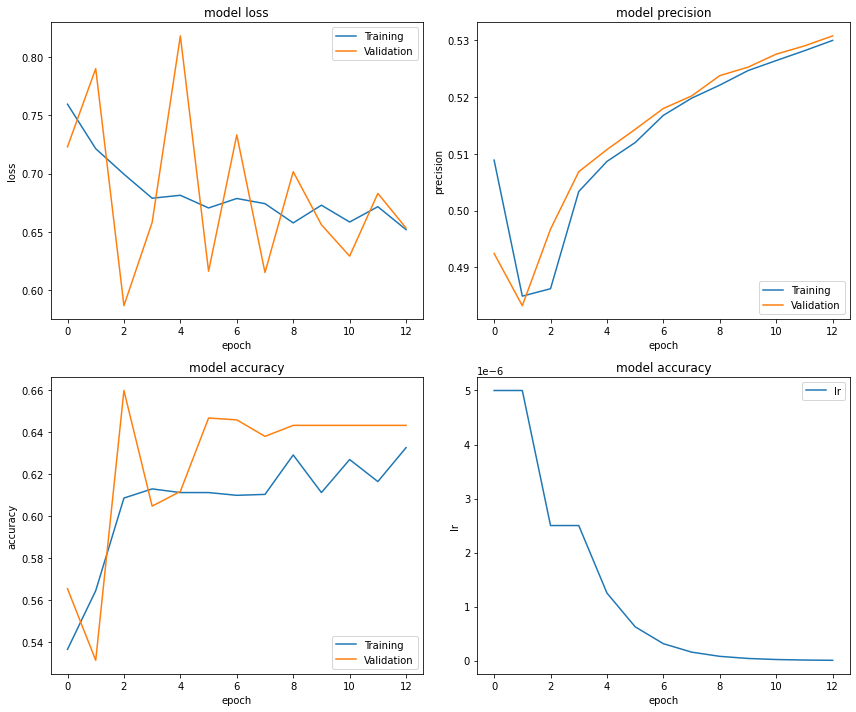

In [70]:
## plot figures
#plot_auc(valY, pred_Y)
plot_history(history)
# Todo

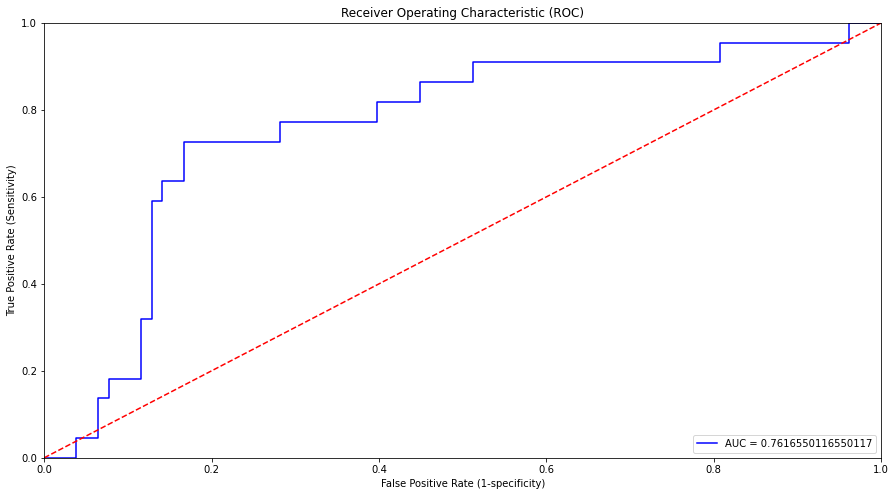

In [95]:
fpr, tpr, thresholds=plot_auc(correct_label, prediction)

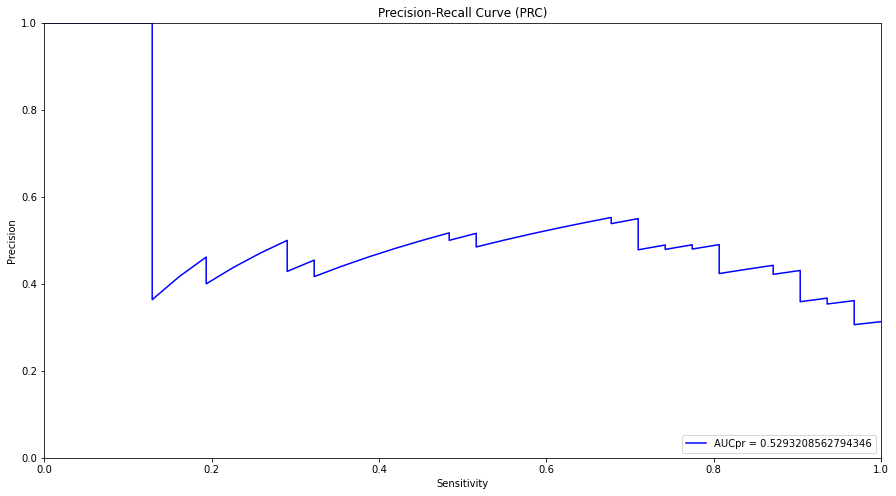

In [117]:
precision, recall, thresholds = plot_prec_recall_curve(correct_label, prediction)

In [118]:
pd.DataFrame({'recall': recall[:-1], 'precision': precision[:-1], 'thresholds': thresholds}).head()

,recall,precision,thresholds
0,1.000000,0.313131,0.196968
1,0.967742,0.306122,0.208908
2,0.967742,0.309278,0.214016
3,0.967742,0.312500,0.233780
4,0.967742,0.315789,0.241168


**Note:** For pneumonia detection, it is crucial that we find all the patients that have pneumonia. Predicting patients with pneumonia as healthy is not acceptable. In other words having high FN is not acceptable. This is measured by recall. Therefore, my approach will be to weight recall over precision. For that reason `F2-score` will be taken instead of `F1-score`.

In [34]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
def f_beta_score_for_threshold(correct_label, prediction, thresh, beta=1, printDF=False):
    df=pd.DataFrame({'prediction':prediction, 'label':correct_label})
    df['threholded prediction'] = df['prediction'].map(lambda x: 1 if x>thresh else 0)
    if printDF:
        print(df.head(10))
    return fbeta_score(df['label'], df['threholded prediction'],beta)

In [52]:
best_score = 0
best_threshold = 0
f2_scoreList = []
for thresh in thresholds:
    f2_score = f_beta_score_for_threshold(correct_label, prediction, beta=2, thresh=thresh, printDF=False)
    f2_scoreList.append(f2_score)
    if f2_score>best_score:
        best_score = f2_score 
        best_threshold = thresh
print(f'Best f2 score = {best_score}, Best threshold = {best_threshold}')

Best f2 score = 0.5090909090909091, Best threshold = 0.6507165431976318


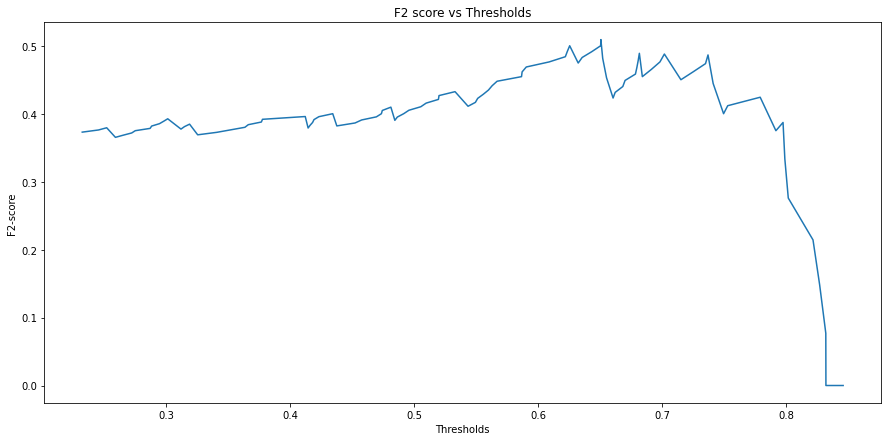

In [53]:
# Plot F2 score vs Thresholds
plot_f_score_thresh(thresholds, f2_scoreList)

**Note:** In the plot above we can see and corroborate the `Best threshold=0.650716` output with an f2-score of 0.509 

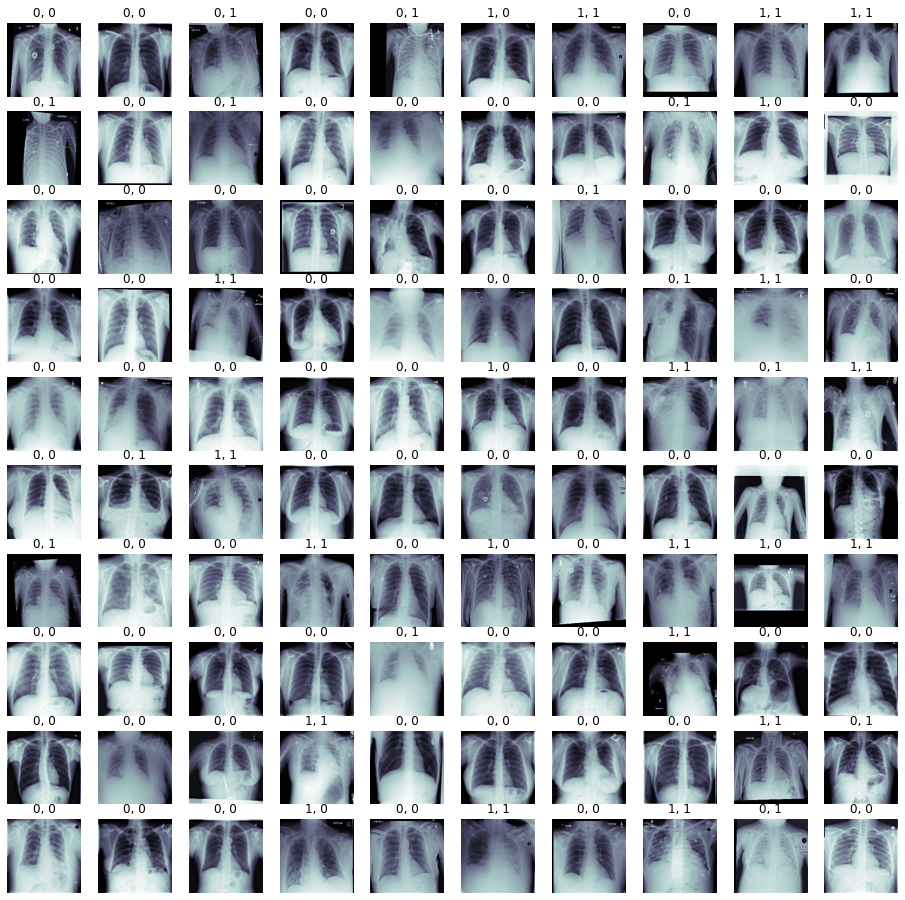

In [101]:
## Let's look at some examples of true vs. predicted with our best model: 
YOUR_THRESHOLD = best_threshold
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], val_Y[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [88]:
## Just save model architecture to a .json:

model_json = myModel.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)